# ARIMA Forecasting Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

Let's have a look at the plot of DL user tput on more time

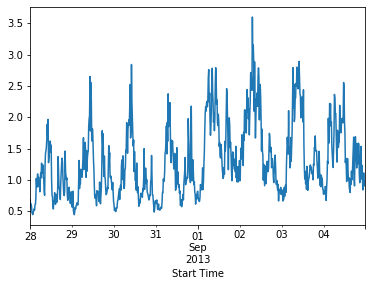

In [3]:
df_filter['DL user tput'].plot()

As we can see above, it is clearly seasonal in nature. The values fluctuate according ot a pattern that is highly repeatable daily. How does that look like in the Auto-Correlation Function ACF plot?

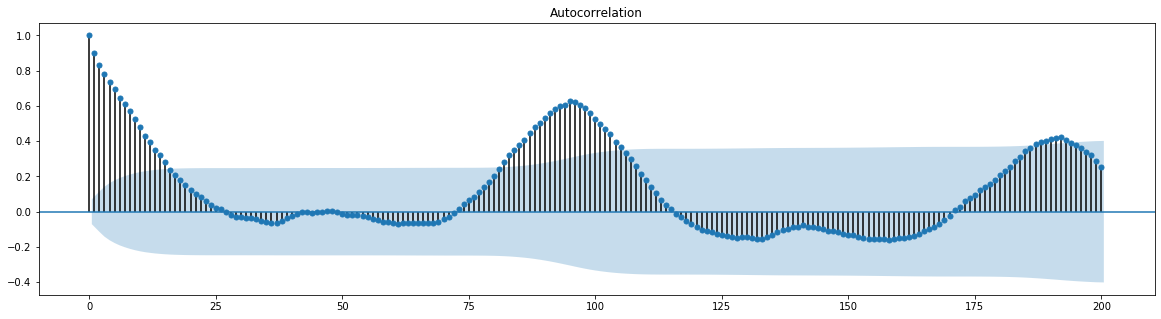

In [4]:
fig,ax=plt.subplots(figsize=(20,5))

plot_acf(df_filter['DL user tput'],ax=ax,lags =200);

The seasonal component is clear above and is consistent with the daily pattern every 96 samples. How does the Partial Auto-Correlation Function PACF plot look like?

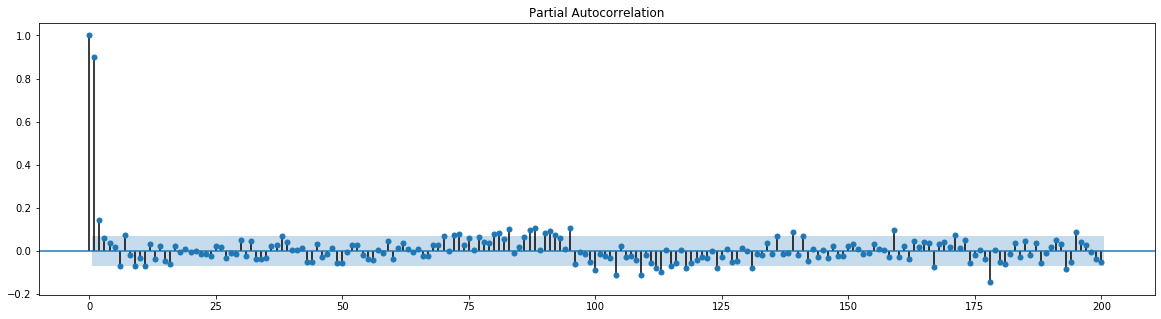

In [5]:
fig,ax=plt.subplots(figsize=(20,5))

plot_pacf(df_filter['DL user tput'],ax=ax,lags =200);

The PACF shows a similar seasonal trend but with much smaller peaks at 96 sample intervals. The highest and only significant peak is at lag 1. This points to the fact that the component that directly affects the next sample is the one before due to the smooth nature of the changes every 15 minutes. The next step is much better predicted by looking at the previous one as they change smoothly from one sample to another either up or down.

What about stationarity?
Stationarity is one major assumption in ARIMA based models in order to model timeseries data(not a strict requirement for ETS for example). Is our signal stationary?



Since the signal is seasonal, then it is not stationary and requires differencing.

How do we approach differencing? Should we do seasonal or lag-1 differencing?
The best approach is to start with seasonal differencing. If more differencing is required the lag-1 differencing is done.


In [3]:
df_filter['1st_diff']=df_filter['DL user tput'].diff(96)
df_filter['1st_diff'].fillna(df_filter['1st_diff'].median(),inplace=True)

Is the signal stationary now? let's check with the ADF test

In [17]:
def adf(x):
  result=adfuller(x)
  print("p-value:",result[1])
  if result[1]<0.05:
    print("Stationary")
  else:
    print("non-stationary")

In [18]:
adf(df_filter['1st_diff'])

p-value: 0.0006446090009782202
Stationary


The signal appears to be stationary now, but is on the borderline. Let's check
the ACF for the 1st seasonal difference

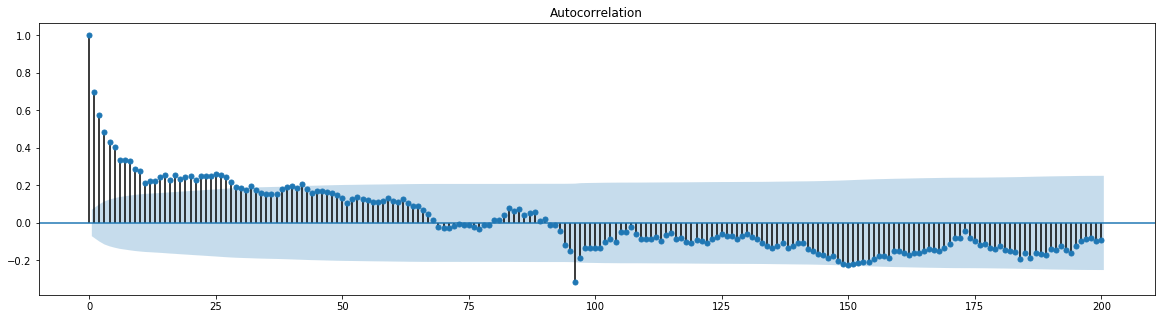

In [19]:
fig,ax=plt.subplots(figsize=(20,5))

plot_acf(df_filter['1st_diff'],ax=ax,lags =200);

The ACF plot still shows a pattern of slow decay for lags up to 25. This points to a signal that is still not fully stationary.
What can we do to improve the stationarity of the signal?
We can do another level of differencing. But since we have already done seasonal differencing, it is recommended to do lag-1 differencing now

In [4]:
df_filter['2nd_diff'] = df_filter['1st_diff'].diff()
df_filter['2nd_diff'].fillna(df_filter['2nd_diff'].median(),inplace=True)

We can assume the signal to be stationary now.
Let's check the ACF and PACF again for the 2nd difference signal and then run the ADF test

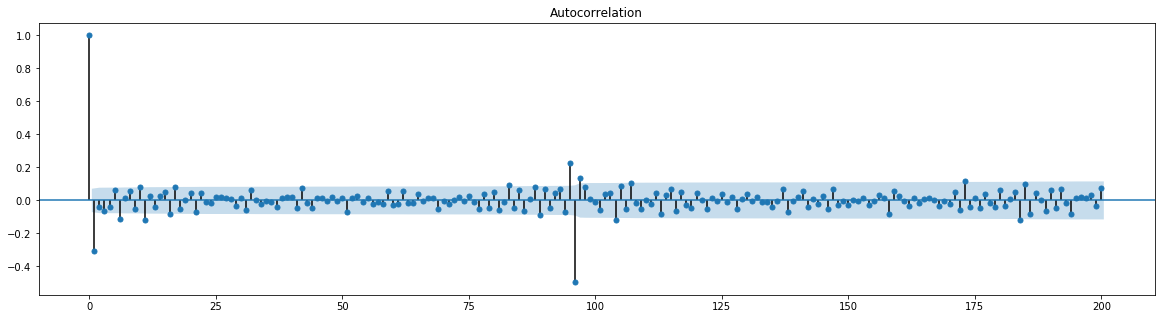

In [24]:
fig,ax=plt.subplots(figsize=(20,5))

plot_acf(df_filter['2nd_diff'],ax=ax,lags =200);

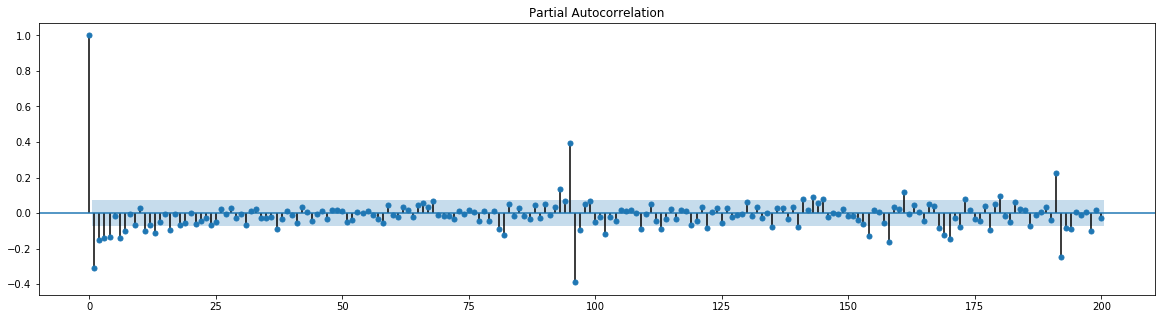

In [25]:
fig,ax=plt.subplots(figsize=(20,5))

plot_pacf(df_filter['2nd_diff'],ax=ax,lags =200);

The cyclical components in the ACF plot are all gone now. There are clear cutoff for both the ACF and the PACF

In [26]:
adf(df_filter['2nd_diff'])

p-value: 3.588051323378782e-19
Stationary


The ADF test confirms that the signal is strongly stationary now.

What is next? How do we approach the modeling process now?
For ARIMA models one needs to find the best set of parameters that give the best accuracy. These parameters are simply the p,d, and q for the non-seasonal part, and the P, D, and Q for the seasonal part

There are two approaches to follow:

1) A method that gives the best performance regardless of model complexity and explainability

Stepwise Auto-ARIMA with AIC/BIC as the metric to minimize (as detailed in https://www.jstatsoft.org/article/view/v027i03)

2) A method that gives the best performance with the least complexity and higher explainability

A gridsearch based approach with a performance metric to minimize (RMSE for example)



Regardless of the approach, one can get a general idea of what range of ARIMA parameters we will be using based on the ACF and PACF plots. Below are the main guidelines:

1) For the differencing part, we need to set d=1 and D=1 as we did both seasonal and lag-1 differencing

2) For the non-seasonal AR and MA components, looking at the PACF and ACF plots, respectively, shows a clear cutoff after lag-1. A good value to choose for both is 1

3) For the seasonal SAR and SMA components, there are clear peaks at lag-96 in PACF and ACF plots. PACF has a peak at lag-192 also. It makes sense to add 1 for the SMA component and at least 1 for the SAR component. 2 could also be an option for SAR

Regardless of the method used we need to create train and test splits for our data

In [7]:
Samtest=96
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]


train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

The first method we will try is the stepwise auto-ARIMA. We can provide the start and max values for the non-seasonal and seasonal parts. The stepwise algorithm will try an initial subset and choose the best model from them. After that it will incrementaly change the best model and repeat the process until the best parameters are found. The algorithm limits the search space this way instead of going ove all possible combinations

In [31]:
model=pm.auto_arima(train['DL user tput'],start_p=0,max_p=1,start_q=0,max_q=1,max_d=1,
                    start_P=0,max_P=2,start_Q=0,max_Q=1,max_D=1,
                    trace=True,suppress_warnings=True,seasonal=True,m=96)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=83.808, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=56.100, Time=13.93 sec
 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=49.919, Time=12.91 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=81.809, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[96] intercept   : AIC=49.171, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[96] intercept   : AIC=49.709, Time=27.62 sec
 ARIMA(0,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=68.42 sec
 ARIMA(1,1,1)(0,0,0)[96] intercept   : AIC=47.935, Time=0.23 sec
 ARIMA(1,1,1)(1,0,0)[96] intercept   : AIC=48.122, Time=28.15 sec
 ARIMA(1,1,1)(0,0,1)[96] intercept   : AIC=48.397, Time=25.96 sec
 ARIMA(1,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=74.38 sec
 ARIMA(1,1,0)(0,0,0)[96] intercept   : AIC=54.979, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[96]             : AIC=45.938, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[96]             : AIC=46.125, Time=17.21 sec
 ARIMA(1,1,1)(0,0,1)[96]             : AIC=46

The best model based on the stepwise auto-ARIMA is the ARIMA(1,1,1)(0,0,0)[96]
As seen above the model has a non-seasonal component only. All seasonal components are set to 0. Let's check the model in details and plot the forecasts for the test set

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -19.969
Date:                Mon, 15 Aug 2022   AIC                             45.938
Time:                        08:27:00   BIC                             59.464
Sample:                             0   HQIC                            51.177
                                - 672                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2736      0.110      2.497      0.013       0.059       0.488
ma.L1         -0.5115      0.102     -5.037      0.000      -0.711      -0.312
sigma2         0.0621      0.003     24.345      0.000       0.057       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.87
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As seen we only have the non-seasonal components p=1, d=1, and q=1. P, D, and Q are all 0

Let's plot the forecast results. For that, we need to define a function that takes the output above and creates the forecasts and the plot

In [5]:
# First function assumes that we do not have any diffrencing and uses all data points in the in-sample train set.
#It generates the forecasts as well as the confidence intervals


def plot_fit_and_forecast(result):
  fig,ax=plt.subplots(figsize=(15,5))
  ax.plot(df_filter['DL user tput'],label='data')

  #plot the train set fitted values
  train_pred=result.fittedvalues
  ax.plot(train.index,train_pred,color='green',label='train fitted')
  
  #test set forecast
  prediction_result=result.get_forecast(Samtest)
  conf_int=prediction_result.conf_int()
  lower,upper=conf_int['lower DL user tput'],conf_int['upper DL user tput']
  forecast=prediction_result.predicted_mean
  ax.plot(test.index,forecast,label='forecast')
  ax.fill_between(test.index,lower,upper,color='red',alpha=0.3)
  ax.legend()


# The second function assumes having lag-1 differencing. This is important as we need to exclude the first datapoint
# from te fitted values. Otherwise we would get an error

def plot_fit_and_forecast_diff(result,d,col='DL user tput'):
  fig,ax=plt.subplots(figsize=(15,5))
  ax.plot(df_filter[col],label='data')

  #plot the train set fitted values
  train_pred=result.predict(start=train.index[d],end=train.index[-1])
  ax.plot(train.index[d:],train_pred,color='green',label='train fitted')
  
  #test set forecast
  prediction_result=result.get_forecast(Samtest)
  conf_int=prediction_result.conf_int()
  lower,upper=conf_int[f'lower {col}'],conf_int[f'upper {col}']
  forecast=prediction_result.predicted_mean
  ax.plot(test.index,forecast,label='forecast')
  ax.fill_between(test.index,lower,upper,color='red',alpha=0.3)
  ax.legend()


    




We have d=1 in our chosen model so we need to use the second function. First we train the model with the parameters selected by the stepwise auto-arima and the run fit. After that we create the forecasts and plot

In [68]:
arima=ARIMA(train['DL user tput'],order=(1,1,1),seasonal_order=(0,0,0,96))
arima_result=arima.fit()


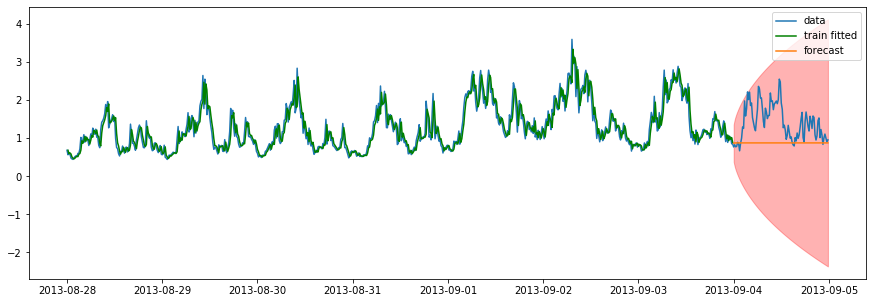

In [70]:
plot_fit_and_forecast_diff(arima_result,d=1)

What we can see above is that the model is practically a linear trend model. In particular is resembles a damped-trend linear exponential smoothing ETS model.
Apparantely the stepwise algorithm has not allowed auto-arima to find the most accurate model as the seasonal components were all ignored. In addition, the non-seasonal AR and MA components were not high enoug to allow the simple ARIMA model to capture the seasonal fluctuations every 96 samples

would the gridsearch based approach give different results? let's setup the a workflow to test it.
The below function allows us to run a gridsearch on a set of possible ARIMA parameters p,d,q,P,D,Q.

In [84]:

def gridsearcharima(AR,d,MA,SAR,SD,SMA,m=96,debug=False):
    """ 
    walk-forward implementation for SARIMA with RMSE as selection metric
    """
    errors=[]
    seen_last=False
    steps_completed=0
    
    #run the below for loop for each combination of parameters. First we use Samtest to do the train/test
    #split for each step
    
    for end_of_train in range(Samtest, len(df_filter)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        #HW model trained for every train set split for each set of parameters
        
        
        arima=ARIMA(train['DL user tput'],order=(AR,d,MA),seasonal_order=(SAR,SD,SMA,m))
        arima_result=arima.fit()

        
        prediction_result=arima_result.get_forecast(h)
        forecast=prediction_result.predicted_mean
        
        #error metric can be either RMSE or R2

        error=np.sqrt(mean_squared_error(test['DL user tput'],forecast))
        #error=r2_score(test['DL user tput'],fcast) 
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
        
        #A list of MSEs for each walkforward step is returned from the function
    return errors

Below is the main workflow that uses itertools to iterate through different set of parameters for a predefined number of steps.
Below we set the number of steps as 1 to keep it simple. It can be increased up to 10 for example

In [83]:


h=96
steps=1
Samtest=len(df_filter)-h-steps+1


AR_list=[1]
d_list=[1]
MA_list=[1]
SAR_list=[1,2]
SD_list=[1]
SMA_list=[0,1]

tupe_of_option_lists=(
    AR_list,
    d_list,
    MA_list,
    SAR_list,
    SD_list,
    SMA_list

)


best_score=float('inf')
best_options=None

#itertools used to input the tuple of parameters to the walk-forward function.

for x in itertools.product(*tupe_of_option_lists):
    score=gridsearcharima(*x)
    
    #Best score is updated based on the mean MSE returned from walkforward function as well as the best params
    if np.mean(score) < best_score:
        print("Best score so far:",score)
        best_score=np.mean(score)
        best_options=x
        print("Best params so far:",best_options)


Best score so far: [0.3795886853866864]
Best params so far: (1, 1, 1, 1, 1, 0)
Best score so far: [0.3136044847737853]
Best params so far: (1, 1, 1, 1, 1, 1)


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Best score so far: [0.3123601206048776]
Best params so far: (1, 1, 1, 2, 1, 1)


The above gridsearch returned the model with the lowest RMSE as (1, 1, 1, 2, 1, 1)
The SAR component is 2. This is kind of consistent with the PACF plot for the seasonal+non-seasonal differenced signal. The gain compared to SAR 1 is not that big and it might be due to overfitting. Walkforward validation by setting step=10 would confirm

As a next step we can also plot the forecast

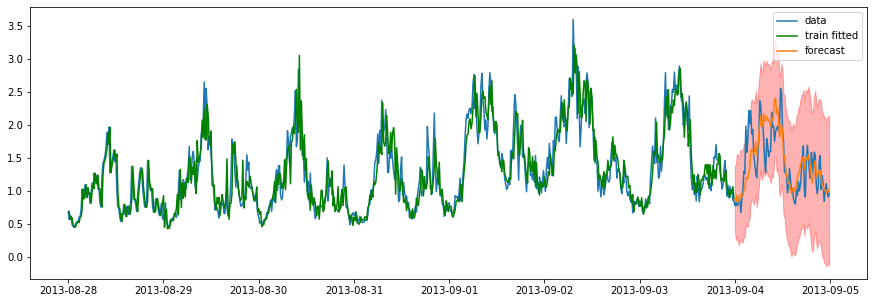

In [11]:
arima=ARIMA(train['DL user tput'],order=(1,1,1),seasonal_order=(2,1,1,96))
arima_result=arima.fit()
plot_fit_and_forecast_diff(arima_result,d=1)

This model performs much better than the one returned by the stepwise procedure. The RMSE value as well as the plot show that it can follow the actual values much closer

In [12]:
def rmsefun(result,is_logged):
  y=result.forecast(Samtest)
  if is_logged:
    y=np.exp(y)
  t=test['DL user tput']
  return np.sqrt(mean_squared_error(t,y))


In [192]:
print("RMSE: order=(1,1,1),seasonal_order=(2,1,1,96)",rmsefun(arima_result,False))

RMSE: 0.3123601206048776


In [194]:
print("RMSE for order=(1,1,1),seasonal_order=(1,1,1,96):",rmsefun(arima_result,False))

RMSE for order=(1,1,1),seasonal_order=(1,1,1,96): 0.3136044847737853


In [214]:
print("RMSE for order=(1,1,1),seasonal_order=(0,1,2,96):",rmsefun(arima_result,False))

RMSE for order=(1,1,1),seasonal_order=(0,1,2,96): 0.313613185835895


In [210]:
print("RMSE for order=(1,1,1),seasonal_order=(0,1,1,96):",rmsefun(arima_result,False))

RMSE for order=(1,1,1),seasonal_order=(0,1,1,96): 0.31276250332170313


In [216]:
print("RMSE for order=(1,1,1),seasonal_order=(1,1,0,96):",rmsefun(arima_result,False))

RMSE for order=(1,1,1),seasonal_order=(1,1,0,96): 0.3795886853866864
